In [275]:
# Homework 2 libs
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import pickle # for the project

from aa598.hw2_helper import simulate_dynamics
import cvxpy as cp
from cbfax.dynamics import *

# Homework 1 libs
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import aa598.hw1_helper as hw1_helper


from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=False) # set to False if latex is not set up on your computer


In [6]:
robot = DynamicallyExtendedSimpleCar() # robot dynamics
human = DynamicallyExtendedSimpleCar() # human dynamics

@jax.jit
def obstacle_constraint(state, obstacle, radius):
    return jnp.linalg.norm(state[:2] - obstacle[:2]) - radius


In [7]:
planning_horizon = 25
num_time_steps = 30
num_sqp_iterations = 15
dt = 0.1
t = 0. # this doesn't affect anything, but a value is needed 
radius = 1. # minimum collision distance

v_max = 1.5
v_min = 0.
acceleration_max = 1.0
acceleration_min = -1.0
steering_max = 0.3
steering_min = -0.3

human_control_prediction_noise_limit = 0.25
human_control_prediction_variance = 0.25


In [8]:
xs = cp.Variable([planning_horizon+1, robot.state_dim])  # cvx variable for states
us = cp.Variable([planning_horizon, robot.control_dim])  # cvx variable for controls
slack = cp.Variable(1) # slack variable to make sure the problem is feasible
As = [cp.Parameter([robot.state_dim, robot.state_dim]) for _ in range(planning_horizon)]  # parameters for linearized dynamics
Bs = [cp.Parameter([robot.state_dim, robot.control_dim]) for _ in range(planning_horizon)] # parameters for linearized dynamics
Cs = [cp.Parameter([robot.state_dim]) for _ in range(planning_horizon)] # parameters for linearized dynamics

Gs = [cp.Parameter([robot.state_dim]) for _ in range(planning_horizon+1)] # parameters for linearized constraints
hs = [cp.Parameter(1) for _ in range(planning_horizon+1)] # parameters for linearized constraints

xs_previous = cp.Parameter([planning_horizon+1, robot.state_dim]) # parameter for previous solution
us_previous = cp.Parameter([planning_horizon, robot.control_dim]) # parameter for previous solution
initial_state = cp.Parameter([robot.state_dim]) # parameter for current robot state



In [9]:
beta1 = 0.2 # coefficient for control effort
beta2 = 2. # coefficient for progress
beta3 = 10. # coefficient for trust region
slack_penalty = 1000. # coefficient for slack variable
markup = 1.0

objective = beta2 * (xs[-1,2]**2 + xs[-1,1]**2 - xs[-1,0]) + beta3 * (cp.sum_squares(xs - xs_previous) + cp.sum_squares(us - us_previous)) + slack_penalty * slack**2
constraints = [xs[0] == initial_state, slack >= 0] # initial state and slack constraint
for t in range(planning_horizon):
    objective += beta1 * cp.sum_squares(us[t]) * markup**t
    constraints += [xs[t+1] == As[t] @ xs[t] + Bs[t] @ us[t] + Cs[t]] # dynamics constraint
    constraints += [xs[t,-1] <= v_max, xs[t,-1] >= v_min, us[t,0] <= acceleration_max, us[t,0] >= acceleration_min, us[t,1] <= steering_max, us[t,1] >= steering_min] # control limit constraints
    constraints += [Gs[t] @ xs[t] + hs[t] >= -slack] # linearized collision avoidance constraint
constraints += [xs[planning_horizon,-1] <= v_max, xs[planning_horizon,-1] >= v_min, Gs[planning_horizon] @ xs[planning_horizon] + hs[planning_horizon] >= 0] # constraints for last planning horizon step
prob = cp.Problem(cp.Minimize(objective), constraints) # construct problem
    


In [10]:
# initial states
robot_state = jnp.array([-3.0, -0., 0., 1.])  # robot starting state
human_state = jnp.array([-1., -2., jnp.pi/2, 1.]) # human starting state

robot_trajectory = [robot_state] # list to collect robot's state as it replans
human_trajectory = [human_state] # list to collect humans's state
robot_control_list = []  # list to collect robot's constrols as it replans
robot_trajectory_list = [] # list to collect robot's planned trajectories
human_control_list = []

# initial robot planned state and controls
previous_controls = jnp.zeros([planning_horizon, robot.control_dim]) # initial guess for robot controls
previous_states =  simulate_dynamics(robot, robot_state, previous_controls, dt) # initial guess for robot states
xs_previous.value = np.array(previous_states) # set xs_previous parameter value
us_previous.value = np.array(previous_controls) # set us_previous parameter value 

# jit the linearize dynamics and constraint functions to make it run faster
linearize_dynamics = jax.jit(lambda states, controls, ti: jax.vmap(linearize, [None, 0, 0, None])(lambda s, c, t: robot.discrete_step(s, c, t, dt), states, controls, ti))
linearize_obstacle = jax.jit(lambda states, controls, radius: jax.vmap(jax.grad(obstacle_constraint), [0, 0, None])(states, controls, radius))

In [11]:
solver = cp.CLARABEL

for t in range(num_time_steps):
    print("timestep: %i"% t)
    initial_state.value = np.array(robot_state)
    # simulate human future trajectory, assuming some noisy behavior
    noisy_human_control = jnp.clip(jnp.array(np.random.randn(planning_horizon, human.control_dim) * human_control_prediction_variance), -human_control_prediction_noise_limit, human_control_prediction_noise_limit)
    human_future = simulate_dynamics(human, human_state, noisy_human_control, dt)
    
    for i in range(num_sqp_iterations):
        # As_value, Bs_value, Cs_value = jax.vmap(linearize, [None, 0, 0, None])(lambda s, c, t: robot.discrete_step(s, c, t, dt), previous_states[:-1], previous_controls, t)
        As_value, Bs_value, Cs_value = linearize_dynamics( previous_states[:-1], previous_controls, t)
        # Gs_value = jax.vmap(jax.grad(obstacle_constraint), [0, 0, None])(previous_states, human_future, radius)
        Gs_value = linearize_obstacle(previous_states, human_future, radius)
        hs_value = jax.vmap(obstacle_constraint, [0, 0, None])(previous_states, human_future, radius) - jax.vmap(jnp.dot, [0, 0])(Gs_value, previous_states)

        for i in range(planning_horizon):
            As[i].value = np.array(As_value[i])
            Bs[i].value = np.array(Bs_value[i])
            Cs[i].value = np.array(Cs_value[i])
            Gs[i].value = np.array(Gs_value[i])
            hs[i].value = np.array(hs_value[i:i+1])
        Gs[planning_horizon].value = np.array(Gs_value[planning_horizon])
        hs[planning_horizon].value = np.array(hs_value[planning_horizon:planning_horizon+1])
        
        result = prob.solve(solver=solver)

        # previous_states = xs.value
        previous_controls = us.value
        previous_states =  simulate_dynamics(robot, robot_state, previous_controls, dt)
        xs_previous.value = np.array(previous_states)
        us_previous.value = np.array(previous_controls)
       
    robot_control = previous_controls[0]
    robot_control_list.append(robot_control)
    # robot takes a step
    robot_state = robot.discrete_step(robot_state, robot_control, 0., dt)
    robot_trajectory.append(robot_state)
    robot_trajectory_list.append(previous_states)

    
    human_random_control = jnp.clip(jnp.array(np.random.randn( human.control_dim) * human_control_prediction_variance), -human_control_prediction_noise_limit, human_control_prediction_noise_limit)
    human_control_list.append(human_random_control)
    # human states a step
    human_state = human.discrete_step(human_state, human_random_control, 0., dt)
    human_trajectory.append(human_state)

human_traj = [human_trajectory]
human_random_cont = (human_random_control)
robot_trajectory = jnp.stack(robot_trajectory)
human_trajectory = jnp.stack(human_trajectory)
robot_controls = jnp.stack(robot_control_list)
human_controls = jnp.stack(human_control_list)




# #Project code
# history_trajectory = jnp.array([robot_trajectory], [robot_control_list],[human_trajectory], [human_random_control])
# with open('history.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(history_trajectory, f, pickle.HIGHEST_PROTOCOL)
# with open('future.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(singleTrainData, f, pickle.HIGHEST_PROTOCOL)


# # Training data
# trajectoryTrainingData = {'xPosition' : robot_trajectory[:-5, 0], 'yPosition' : robot_trajectory[:-5, 1],
#         'heading' : robot_trajectory[:-5, 2], 'velocity' : robot_trajectory[:-5, 3]}
# with open('robot_trajectory_train_v3.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(trajectoryTrainingData, f, pickle.HIGHEST_PROTOCOL)
# # Testing data
# trajectoryTestingData = {'xPosition' : robot_trajectory[-5:, 0], 'yPosition' : robot_trajectory[-5:, 1],
#         'heading' : robot_trajectory[-5:, 2], 'velocity' : robot_trajectory[-5:, 3]}
# with open('robot_trajectory_test_v3.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(trajectoryTestingData, f, pickle.HIGHEST_PROTOCOL)
    

timestep: 0
timestep: 1
timestep: 2
timestep: 3
timestep: 4
timestep: 5
timestep: 6
timestep: 7
timestep: 8
timestep: 9
timestep: 10
timestep: 11
timestep: 12
timestep: 13
timestep: 14
timestep: 15
timestep: 16
timestep: 17
timestep: 18
timestep: 19
timestep: 20
timestep: 21
timestep: 22
timestep: 23
timestep: 24
timestep: 25
timestep: 26
timestep: 27
timestep: 28
timestep: 29


In [12]:
# plotting
@interact(i=(0,num_time_steps-1))
def plot(i):
    fig, axs = plt.subplots(1,2, figsize=(18,8))
    ax = axs[0]
    robot_position = robot_trajectory[i, :2]
    human_position = human_trajectory[i, :2]
    circle1 = plt.Circle(robot_position, radius / 2, color='C0', alpha=0.4)
    circle2 = plt.Circle(human_position, radius / 2, color='C1', alpha=0.4)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    # ax.plot(human_samples[i,:,:,0].T, human_samples[i,:,:,1].T, "o-", alpha=0.1, markersize=2, color='C1')
    ax.plot(robot_trajectory[:,0], robot_trajectory[:,1], "o-", markersize=3, color='C0')
    ax.plot(robot_trajectory_list[i][:,0], robot_trajectory_list[i][:,1], "o-", markersize=3, color='C2', label="planned")
    print(robot_trajectory[i])

    ax.plot(human_trajectory[:,0], human_trajectory[:,1], "o-", markersize=3, color='C1')
    ax.scatter(robot_trajectory[i:i+1,0], robot_trajectory[i:i+1,1], s=30,  color='C0', label="Robot")
    ax.scatter(human_trajectory[i:i+1,0], human_trajectory[i:i+1,1], s=30,  color='C1', label="Human")
    ax.grid()
    ax.legend()

    ax.set_xlim([-4,4])
    ax.set_ylim([-3, 2])
    ax.axis("equal")

    ax.set_title("heading=%.2f velocity=%.2f"%(robot_trajectory[i,2], robot_trajectory[i,3]))
    
    ax = axs[1]
    plt.plot(robot_controls)
    plt.scatter([i], robot_controls[i:i+1, 0], label="Acceleration")
    plt.scatter([i], robot_controls[i:i+1, 1], label="Steering")
    ax.plot(robot_trajectory[:,-1], "o-", markersize=3, color='C0', label="Velocity")

    ax.legend()
    ax.grid()
    

interactive(children=(IntSlider(value=14, description='i', max=29), Output()), _dom_classes=('widget-interact'…

In [260]:
with open("data/hw1/wave_data_train.pickle", 'rb') as handle:
    wave_data = pickle.load(handle)
history = wave_data["history"]
future = wave_data["future"]
print((future))

[[-0.77215546 -0.8842893  -0.9601989  -0.9967745  -0.99251807]
 [-0.33736357 -0.6201609  -0.83809453 -0.96837014 -0.99736214]
 [-0.9241497  -0.9772044  -0.9993569  -0.98990667 -0.9491525 ]
 ...
 [ 0.8635387   0.84961313  0.8350685   0.8199155   0.80416495]
 [-0.78483945 -0.86998636 -0.934877   -0.9780004  -0.9983526 ]
 [ 0.9903264   0.98666096  0.8932651   0.7186327   0.47864532]]


In [68]:
zero_row = jnp.zeros((1, 2))
if (robot_controls[0] != 0).all():
    robot_controls = jnp.vstack([zero_row, robot_controls])
if (human_controls[0] != 0).all():
    human_controls = jnp.vstack([zero_row, human_controls])

totalMatrix = jnp.concatenate([robot_trajectory, robot_controls, human_trajectory, human_controls], axis = 1) 
# standardMatrix = jax.nn.standardize(totalMatrix)
totalMatrix = np.array(totalMatrix)
print(type(totalMatrix))

<class 'numpy.ndarray'>


In [79]:
print(totalMatrix[-1, :])

[-1.7492138  -0.11980201 -0.08769828  0.5093328   0.2281988   0.08682334
 -1.2051659   1.0659729   1.6804698   1.0362684   0.10428917  0.06846888]


In [70]:
A = np.random.rand(4, 4)
print(A)

[[0.66461888 0.22864965 0.73637895 0.76078417]
 [0.53598473 0.97991528 0.14889684 0.944559  ]
 [0.46502261 0.13147021 0.64624878 0.70144144]
 [0.70992977 0.34738369 0.9379141  0.53920121]]


In [265]:
new_data = np.delete(A, [1, 2], axis=1)
# 
# print(np.size(totalMatrix))
# print(totalMatrix[:, 4:6])
onlyHistoryData = np.delete(totalMatrix, [4, 6], axis = 1) # deleting the 4, 5 row because this is 'x'
onlyTestData = (totalMatrix[:, 4:6])
train_data_history = np.transpose(onlyHistoryData[:15, :])
train_data_future = np.transpose(onlyTestData[:15, :])
test_data_history = np.transpose(onlyHistoryData[:15, :])
test_data_future = np.transpose(onlyTestData[15:, :])
train_data = {'history' : train_data_history, 'future' : train_data_future}
test_data = {'history' : test_data_history, 'future' : test_data_future}
print(len(train_data['history']))
print(train_data['future'])
print(len(train_data['history']))
print((test_data['future']))

10
[[ 0.         -1.         -0.9672812  -0.9216062  -0.7085611  -0.73266715
  -0.5510376  -0.40168682 -0.3386919  -0.40357587 -0.46862218 -0.3027431
  -0.3581929  -0.38827908 -0.2142461 ]
 [ 0.         -0.3        -0.29999998 -0.29819578 -0.17243247 -0.25088796
  -0.1496075  -0.07902728 -0.04207991 -0.03483106 -0.04037986 -0.00954861
  -0.00252429  0.00285924  0.01644439]]
10
[[-0.08479883  0.01112014  0.08181445  0.13351025  0.1708963   0.19749525
   0.21596232  0.22829543  0.23599875  0.24021141  0.2417915   0.24138965
   0.2394965   0.2364883   0.2326498   0.2281988 ]
 [ 0.02585071  0.03278644  0.03835532  0.04324008  0.0478334   0.05233175
   0.05680311  0.06123573  0.06557198  0.06973232  0.07363143  0.0771886
   0.08033409  0.08301231  0.08518346  0.08682334]]


In [266]:
# This will be the training data
with open('train.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(train_data, f, pickle.HIGHEST_PROTOCOL)
# This will be the testing data
with open('test.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(test_data, f, pickle.HIGHEST_PROTOCOL)
# When training will have to leave out the testing robot controls

In [268]:
with open("train.pickle", 'rb') as handle:
    train = pickle.load(handle)
with open("test.pickle", 'rb') as handle:
    test = pickle.load(handle)
# print((test.shape))
# print((train.shape))

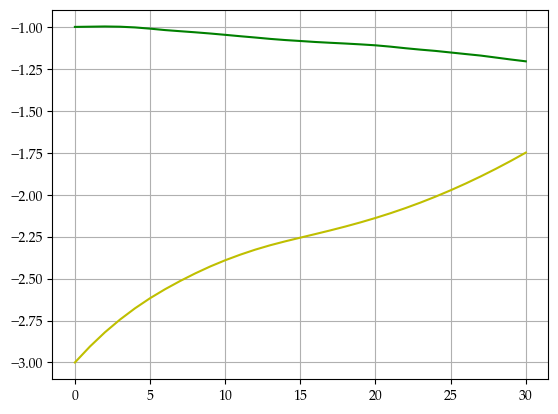

In [269]:
t = np.arange(0,31)
# print((totalMatrix))
# plt.plot(t, standardMatrix[0:31, 0], color  = 'r') # Robot controls
# plt.plot(t, standardMatrix[0:31, 6], color  = 'b') # Human controls
plt.plot(t, totalMatrix[0:31, 0], color  = 'y') # Robot controls
plt.plot(t, totalMatrix[0:31, 6], color  = 'g') # Human controls
plt.grid()

## LSTM

In [276]:
# feel free to poke around the data
# THIS NEEDS TO BE REVIEWED
test_data = hw1_helper.TrajectoryData("test")
train_data = hw1_helper.TrajectoryData("train")


# history_length = 3 # Number of backward steps considered to train
# future_length = 3 # Number of forward considered to train
# input_size = 10
# output_size = 10


KeyError: (slice(None, None, None), slice(4, 6, None))

In [240]:
# with open("data/hw1/wave_data_test.pickle", 'rb') as handle:
#     wave_data = pickle.load(handle)
# print(wave_data['history'].shape)
# print(wave_data['future'].shape)
# print(wave_data['future'])
print(test_data[:,:])
# print(train_data[:, :])

(tensor([[-2.2560e+00, -6.5145e-02, -1.2251e-01,  2.1580e-01, -8.4799e-02,
          2.5851e-02, -1.0840e+00, -4.4290e-01,  1.6284e+00,  9.9145e-01,
          1.5417e-01,  1.9350e-03],
        [-2.2345e+00, -6.7781e-02, -1.2181e-01,  2.1691e-01,  1.1120e-02,
          3.2786e-02, -1.0899e+00, -3.4377e-01,  1.6314e+00,  9.9463e-01,
          3.1814e-02,  3.0392e-02],
        [-2.2126e+00, -7.0457e-02, -1.2096e-01,  2.2509e-01,  8.1814e-02,
          3.8355e-02, -1.0947e+00, -2.4435e-01,  1.6060e+00,  9.9610e-01,
          1.4679e-02, -2.5000e-01],
        [-2.1896e+00, -7.3242e-02, -1.1995e-01,  2.3845e-01,  1.3351e-01,
          4.3240e-02, -1.0991e+00, -1.4367e-01,  1.6240e+00,  1.0194e+00,
          2.3337e-01,  1.7746e-01],
        [-2.1651e+00, -7.6183e-02, -1.1877e-01,  2.5554e-01,  1.7090e-01,
          4.7833e-02, -1.1041e+00, -4.3102e-02,  1.6163e+00,  9.9444e-01,
         -2.5000e-01, -7.6240e-02],
        [-2.1387e+00, -7.9310e-02, -1.1738e-01,  2.7528e-01,  1.9750e-01,
     

In [220]:
    
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        
        # HINT: Use Pytorch built-in functions for LSTM and Linear layers.
        # HINT: batch dimension is dim=0

        '''
        looking at the code provided on pytorch

        
        nn.LSTM is looking for an input and an output without specifying that it is
        being used as an encoder or a decoder so it can be reversed?

        nn.Linear is a transformation that turn the output into a linearized equation where y = Ax + b
            b is the bias
            A is the weight
            y is the output
        '''
        
        # TODO: Define encoder LSTM.
        self.encoder = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
        ############################
        
        
        # TODO: Define decoder LSTM
        self.decoder = torch.nn.LSTM(input_dim, hidden_dim, batch_first=True)
        ############################
        
        
        #TODO: Define linear project from hidden_dim to output_dim
        # The output is a scalar but it needs to be an array [~,4]
        self.projection = torch.nn.Linear(hidden_dim, output_dim, bias = False)
        ############################
        

    def forward(self, x, t_max, y=None, prob=1.):
        """
        Forward pass of the LSTM model.
        x: The input sequence [batch_size, seq_len, input_dim]
        t_max: maximum time steps to unroll
        y: The target sequence for teacher forcing (optional, used if teacher forcing is applied) [batch_size, t_max, output_dim]
        prob: Probability to apply teacher forcing (0 to 1). 1 means 100% teacher forcing, 
        """
        
        # making sure x and y is the appropriate size.
        if len(x.shape) == 2:
            x = x.unsqueeze(-1)
        if y is not None and len(y.shape) == 2:
            y = y.unsqueeze(-1)
        
        
        ys = [] # collect outputs
        # TODO: Run input through encoder to get initial hidden state for decoder
        _, h = self.encoder(x)
        ############################
        
        
        # TODO: initial state for decoder is last input state
        y_input = x[:,-1, :]
        y_input = y_input.unsqueeze(1)
        ############################
        

        # TODO: unroll decoder 
        # TODO: if eval or no teacher forcing, use prediction from previous step
        # TODO: if train and using teacher forcing, use prob to determine whether to use ground truth or previous prediction
        
        ############################
        for i in range(t_max):
            output, h = self.decoder(y_input, h)
            output = self.projection(output)
            # TODO: y_input = ...?
            random = torch.rand([1, 1])
            if random >= 0.7:
                y_input = output
            else:
                y_input = y_input
            # y_input = output
            ys.append(output.squeeze(1))
        ys = torch.cat(ys, dim=1)
    
        
        return ys # [batch_size, ts_max, output_dim]

In [224]:
hidden_size = 1
future_length = 2
input_size = 1
output_size = 1

model = LSTM(input_size, output_size, hidden_size)

learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
prob = 0.

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


def prob_schedule(i):
    return 1 - jax.nn.sigmoid(20 * (i - 0.5)).item()



In [225]:
# we use a slightly different training loop to account for teacher forcing
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    prob = prob_schedule((epoch + 1)/num_epochs)
    for batch_idx, (data, target) in enumerate(train_dataloader):
        optimizer.zero_grad()        # Zero the gradients
        output = model(data, future_length, target, prob)         # Forward pass
        loss = criterion(output, target)  # Compute loss
        loss.backward()              # Backpropagation
        optimizer.step()             # Update weights

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

    print(f'Epoch {epoch+1} completed with average loss: {running_loss/len(train_dataloader):.4f}')

print("Training finished!")


Epoch [1/10], Step [0/1], Loss: 0.3988
Epoch 1 completed with average loss: 0.3988
Epoch [2/10], Step [0/1], Loss: 0.4038
Epoch 2 completed with average loss: 0.4038
Epoch [3/10], Step [0/1], Loss: 0.4023
Epoch 3 completed with average loss: 0.4023
Epoch [4/10], Step [0/1], Loss: 0.4008
Epoch 4 completed with average loss: 0.4008
Epoch [5/10], Step [0/1], Loss: 0.3931
Epoch 5 completed with average loss: 0.3931
Epoch [6/10], Step [0/1], Loss: 0.3978
Epoch 6 completed with average loss: 0.3978
Epoch [7/10], Step [0/1], Loss: 0.3963
Epoch 7 completed with average loss: 0.3963
Epoch [8/10], Step [0/1], Loss: 0.3948
Epoch 8 completed with average loss: 0.3948
Epoch [9/10], Step [0/1], Loss: 0.3874
Epoch 9 completed with average loss: 0.3874
Epoch [10/10], Step [0/1], Loss: 0.3860
Epoch 10 completed with average loss: 0.3860
Training finished!


In [226]:
# evaluate on a test set. 
model.eval()
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)
for (history, future) in test_dataloader:
    prediction = model(history, future_length)         # Forward pass
    loss = criterion(prediction, future)  # Compute loss
    
# print out test loss
print(f'Test Loss: {loss.item():.4f}')


# try with different prediction horizons
prediction_horizon = 2
prediction = model(history, prediction_horizon)


# Visualize prediction on test data
test_dataloader = list(DataLoader(test_data, batch_size=1, shuffle=False))
index_slider = widgets.IntSlider(value=0, min=0, max=len(test_dataloader)-1, step=1, description='Index:')
xlims = [-11, prediction_horizon + 2]
ylims = [-5,5]
interact(hw1_helper.plot_data_regression, history=widgets.fixed(history), future=widgets.fixed(future), prediction=widgets.fixed(prediction), index=index_slider, xlims=widgets.fixed(xlims), ylims=widgets.fixed(ylims))



Test Loss: 0.0356


interactive(children=(IntSlider(value=0, description='Index:', max=15), Output()), _dom_classes=('widget-inter…

<function aa598.hw1_helper.plot_data_regression(history, future, prediction, index, xlims=[-11, 5], ylims=[-2, 2])>

In [231]:
print(prediction[:, 0])
print(prediction[:, 1])

tensor([0.1905, 0.1934, 0.1467, 0.2180, 0.1735, 0.2213, 0.2233, 0.1944, 0.1521,
        0.1967, 0.2283, 0.1451, 0.2225, 0.2265, 0.1489, 0.2009],
       grad_fn=<SelectBackward0>)
tensor([0.2910, 0.2951, 0.2396, 0.3194, 0.2745, 0.3238, 0.3271, 0.2959, 0.2460,
        0.2967, 0.3293, 0.2392, 0.3267, 0.3285, 0.2408, 0.3023],
       grad_fn=<SelectBackward0>)


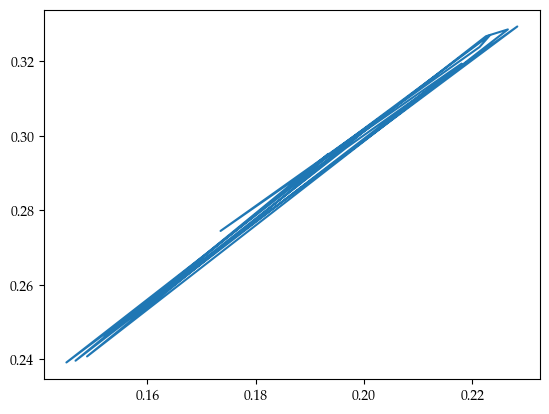

In [227]:
t = np.linspace(0,16, 16)
# plt.plot(t, prediction[:, 0].detach().numpy())
plt.plot(prediction[:, 0].detach().numpy(), prediction[:, 1].detach().numpy())

Text(0, 0.5, 'y axis')

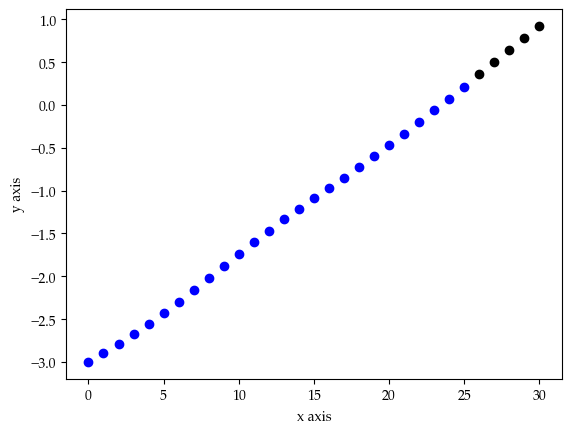

In [116]:
t = jnp.arange(0, len(trainXPosition), 1)
j = jnp.arange(0, len(testXPosition), 1)
plt.scatter(t, trainXPosition, color='b')
plt.scatter(j+len(trainXPosition), testXPosition , color = 'k')
# plt.scatter(j+len(trainXPosition), prediction)
plt.xlabel('x axis')
plt.ylabel('y axis')

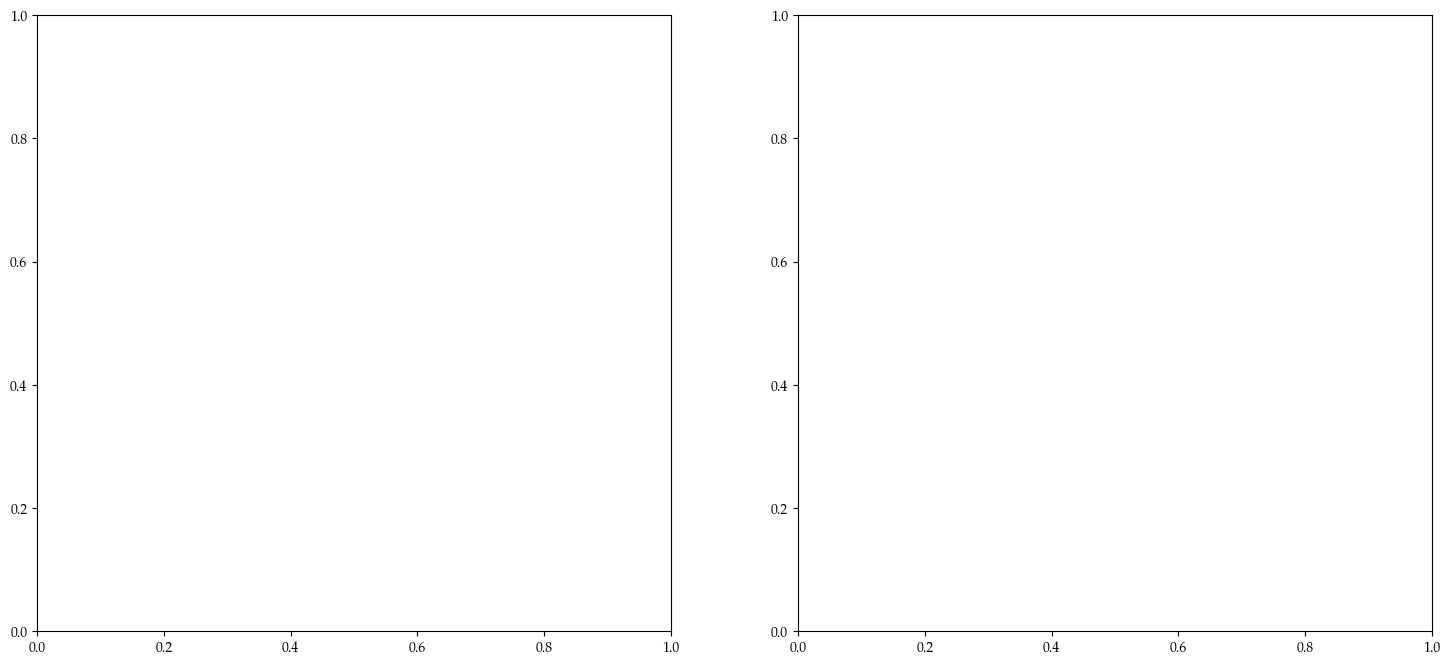

interactive(children=(IntSlider(value=14, description='i', max=29), Output()), _dom_classes=('widget-interact'…

In [52]:
# plotting
@interact(i=(0,num_time_steps-1))
def plot(i):
    fig, axs = plt.subplots(1,2, figsize=(18,8))
    ax = axs[0]
    robot_position = train_data[i]
    circle1 = plt.Circle(robot_position, radius / 2, color='C0', alpha=0.4)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    # ax.plot(human_samples[i,:,:,0].T, human_samples[i,:,:,1].T, "o-", alpha=0.1, markersize=2, color='C1')
    ax.plot(train_data[0], train_data[1], "o-", markersize=3, color='C0')
    ax.plot(train_data[i][0], train_data[i][1], "o-", markersize=3, color='C2', label="planned")
    ax.scatter(train_data[i:i+1], train_data[i:i+1], s=30,  color='C0', label="Robot")
    ax.grid()
    ax.legend()

    ax.set_xlim([-4,4])
    ax.set_ylim([-3, 2])
    ax.axis("equal")

    ax.set_title("heading=%.2f velocity=%.2f"%(robot_trajectory[i,2], robot_trajectory[i,3]))